Here, we'll try to fit our very first model on TennisExplorer data

In [1]:
from tennis_new.fetch.tennis_explorer.combiner import read_joined

jd = read_joined()

/Users/siddhantjagadish/Documents/DataProjects/tennis_new/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3214: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


In [2]:
jd.shape

(952932, 31)

#### Back to Fitting

In [65]:
from library import eval_mod, missing_pids, missing_score_error, possible_walkover

bad_rows = missing_pids(jd) | missing_score_error(jd)
rel = jd[~bad_rows]

In [66]:
from tennis_new.ml.elo import ELOModel

In [94]:
unfiltered_elo = ELOModel(winner_mod=True)

In [95]:
unfiltered_elo.fit_and_backfill(
    rel['p1_link'],
    rel['p2_link'],
    rel['match_link']
)

In [96]:
rel.shape

(952869, 31)

In [97]:
unfiltered_eval = eval_mod(unfiltered_elo, rel, test_surface=None)
unfiltered_eval

224662


{'overall_accuracy': 0.7275996830794705,
 'odds_accuracy': 0.7200428690759507,
 'model_odds_accuracy': 0.7074658387051017,
 'n_w_odds': 63449}

In [78]:
good_filter = (~(
    rel['p1_set1'].isnull() |
    (rel['p1_sets_won'].isnull())
)).values.astype(int)
good_filter = (~(
    possible_walkover(rel)
))

In [76]:
# Try fitting with filter
filtered_elo = ELOModel(winner_mod=True)
filtered_elo.fit_and_backfill(
    rel['p1_link'],
    rel['p2_link'],
    rel['match_link'],
    filter_mask=good_filter
)

In [77]:
first_eval = eval_mod(filtered_elo, rel, test_surface=None)
first_eval

224662


{'overall_accuracy': 0.7271946301555225,
 'odds_accuracy': 0.7200428690759507,
 'model_odds_accuracy': 0.7080805056029252,
 'n_w_odds': 63449}

In [88]:
first_eval = eval_mod(filtered_elo, rel, test_surface='hard')
first_eval

17561


{'overall_accuracy': 0.7073059620750527,
 'odds_accuracy': 0.7120073608342279,
 'model_odds_accuracy': 0.6965189388130655,
 'n_w_odds': 13042}

#### Tune Surface Weights

Let's start with hard...

In [80]:
from tennis_new.ml.sobol import generate_sobol_seq, get_range_values

N_TRIALS = 100

sobol_vals = generate_sobol_seq(4, N_TRIALS, 1)
clay = sobol_vals[:, 0]
indoors = sobol_vals[:, 1]
grass = sobol_vals[:, 2]
var = sobol_vals[:, 3]

In [81]:
rel['surface'].value_counts()

clay                122332
hard                 96797
indoors              50470
grass                15223
Various surfaces      6851
Name: surface, dtype: int64

In [82]:
rel['surface'].fillna('Various surfaces', inplace=True)

/Users/siddhantjagadish/Documents/DataProjects/tennis_new/venv/lib/python3.7/site-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [83]:
from tqdm.autonotebook import tqdm

out = []
for c, i, g, v in tqdm(zip(clay, indoors, grass, var)):
    cur_weight_dict = {
        'clay': c,
        'hard': 1.,
        'indoors': i,
        'grass': g,
        'Various surfaces': v
    }
    weights = rel['surface'].map(lambda x: cur_weight_dict[x])
    filtered_elo = ELOModel(winner_mod=True)
    filtered_elo.fit_and_backfill(
        rel['p1_link'],
        rel['p2_link'],
        rel['match_link'],
        weights=weights
    )
    cur_eval = eval_mod(filtered_elo, rel, test_surface='hard')
    cur_eval.update(cur_weight_dict)
    out.append(cur_eval)

17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561
17561



In [84]:
import pandas as pd

out_df = pd.DataFrame(out)
out_df.sort_values('model_odds_accuracy', ascending=False, inplace=True)
out_df.head()

,Various surfaces,clay,grass,hard,indoors,model_odds_accuracy,n_w_odds,odds_accuracy,overall_accuracy
34,0.328125,0.296875,0.859375,1.0,0.515625,0.701963,13042,0.712007,0.708787
38,0.453125,0.171875,0.484375,1.0,0.890625,0.701426,13042,0.712007,0.710609
82,0.398438,0.367188,0.914062,1.0,0.867188,0.701043,13042,0.712007,0.709982
14,0.312500,0.062500,0.687500,1.0,0.937500,0.700889,13042,0.712007,0.707192
86,0.273438,0.242188,0.289062,1.0,0.742188,0.700813,13042,0.712007,0.706452


In [85]:
weight_cols = [
    'Various surfaces',
    'clay',
    'grass',
    'indoors',
]

final_weights = dict(out_df[out_df['model_odds_accuracy'] > 0.7][weight_cols].mean(axis=0))
final_weights

{'Various surfaces': 0.3828125,
 'clay': 0.2265625,
 'grass': 0.5755208333333334,
 'indoors': 0.7994791666666666}

In [ ]:
# TODO: Let's fit a metamodel to figure out the surface effects

In [89]:
import numpy as np
from scipy.stats import chi2_contingency


n = first_eval['n_w_odds']
ns = int(0.701963 * n)
nf = n - ns

ns_control = int(0.6965 * n)
nf_control = n - ns_control

_, p, _, _ = chi2_contingency(
    np.array([
        [ns, nf],
        [ns_control, nf_control]
    ])
)

In [90]:
p

0.33776556274726416

We've tuned above, but gotten results that look a little strange!  The top weights don't seem similar at all, and it seems very strange to be assigning a high weight to grass to predict clay court matches.  The improvement is also not statistically significant

In [92]:
test_eval = eval_mod(
    unfiltered_elo,
    rel,
    test_min='2015-01-01',
    test_max='2020-01-01',
    test_surface='hard'
)
test_eval

24345


{'overall_accuracy': 0.6836722119531732,
 'odds_accuracy': 0.6960634726884345,
 'model_odds_accuracy': 0.6822878067919265,
 'n_w_odds': 22939}

In [101]:
final_weights.update({'hard': 1.})

In [102]:
tuned_elo = ELOModel(winner_mod=True)
_w = rel['surface'].map(lambda x: final_weights[x])
tuned_elo.fit_and_backfill(
    rel['p1_link'],
    rel['p2_link'],
    rel['match_link'],
    weights=_w
)

test_tuned_eval = eval_mod(
    tuned_elo,
    rel,
    test_min='2015-01-01',
    test_max='2020-01-01',
    test_surface='hard'
)
test_tuned_eval

24345


{'overall_accuracy': 0.6835489833641405,
 'odds_accuracy': 0.6960634726884345,
 'model_odds_accuracy': 0.6833776537774097,
 'n_w_odds': 22939}

The tuning helps a little bit on the test set, but not a ton...

#### Look at Calibration

Let's look at calibration just for 3-set matches

In [111]:
from library import get_test_set

val_period = get_test_set(
    rel,
    test_surface='hard'
).copy()

val_period = pd.merge(
    val_period,
    pd.DataFrame(tuned_elo.history),
    left_on='match_link',
    right_on='match_id'
)

In [112]:
sorted(val_period.columns)

['comment',
 'date',
 'details',
 'elo1',
 'elo2',
 'elo_match_prediction',
 'match_id',
 'match_link',
 'match_time',
 'p1_id',
 'p1_link',
 'p1_name',
 'p1_odds',
 'p1_seed',
 'p1_set1',
 'p1_set2',
 'p1_set3',
 'p1_set4',
 'p1_set5',
 'p1_sets_won',
 'p2_id',
 'p2_link',
 'p2_name',
 'p2_odds',
 'p2_seed',
 'p2_set1',
 'p2_set2',
 'p2_set3',
 'p2_set4',
 'p2_set5',
 'p2_sets_won',
 'sex',
 'surface',
 'tourney_link',
 'tourney_name',
 'tourney_prize_money',
 'tourney_type']

In [113]:
import numpy as np

rel = val_period[val_period['p1_sets_won'] == 2]
preds = rel['elo_match_prediction'].values
ys = np.ones(len(rel))
reverse_preds = 1. - preds
reverse_ys = np.zeros(len(rel))
preds = np.concatenate([preds, reverse_preds])
ys = np.concatenate([ys, reverse_ys])

Text(0.5, 0, 'Predicted Prob.')

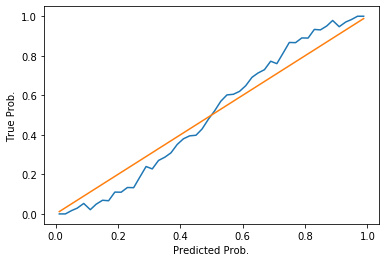

In [116]:
%matplotlib inline
from sklearn.calibration import calibration_curve
from matplotlib import pyplot as plt

_y, _x = calibration_curve(ys, preds, n_bins=50)
plt.plot(_x, _y)
plt.plot(_x, _x)
plt.ylabel("True Prob.")
plt.xlabel("Predicted Prob.")

My predictions should be a bit more extreme...Looks like I just need to put things through some sort of an s-curve for calibration -- this is convenient! 